In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import requests

In [2]:
## Cargar fuente Pricestats

pd.read_csv('./../data/info/Argentina_inflation_pricestats.csv')

cpi = pd.read_csv('./../data/info/Argentina_inflation_pricestats.csv').dropna(subset = ['index'])
# cpi.index = pd.date_range("1943-01", periods=len(cpi), freq = 'M')
cpi.index = pd.date_range("1942-12", periods=len(cpi), freq = 'M') + pd.DateOffset(days=15)

## Cargar fuente Indec para IPC post 2015
### Descargar info actualizada en ipc_b201612_mensual.csv
csv_url = 'https://infra.datos.gob.ar/catalog/sspm/dataset/145/distribution/145.3/download/indice-precios-al-consumidor-nivel-general-base-diciembre-2016-mensual.csv'
req = requests.get(csv_url)
csv_file = open('./../data/info/ipc_b201612_mensual.csv', 'wb')
csv_file.write(req.content)
csv_file.close()

## Usar archivo
cpi2 = pd.read_csv('./../data/info/ipc_b201612_mensual.csv',
                   usecols = ['ipc_ng_nacional']).astype(float)
# cpi2.index = pd.date_range("2016-12", periods=len(cpi2), freq = 'M')
cpi2.index = pd.date_range("2016-11", periods=len(cpi2), freq = 'M') + pd.DateOffset(days=15)

cpi2.columns = ['index']

### Graficar el empalme de indices

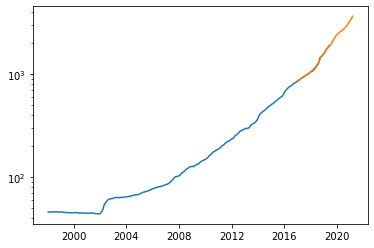

In [3]:
m = np.mean(cpi.loc['2017':]['index'].values/cpi2.loc['2017':]['index'].values[:len(cpi.loc['2017':])])

plt.plot(cpi.loc['1998':][['index']])
plt.plot(m*cpi2.loc['2017':][['index']])

plt.yscale('log')
plt.show()

In [4]:
## Si esta todo ok se pueden unir
cpi = pd.concat([cpi.loc[:cpi2.index.values[0]][['index']],
           m*cpi2.iloc[1:]], )

In [5]:
cpi.tail()

,index
2020-11-15,3108.001733
2020-12-15,3232.494835
2021-01-15,3363.379502
2021-02-15,3483.607931
2021-03-15,3651.197603


In [6]:
## Tasa de inflacion de los ultimos 12 meses. Se usa para completar la inflacion del ultimo mes antes que se mida.
r = cpi.pct_change().tail(6).mean()[0]
print(r)

## Estirar la serie de CPI hasta el dia de hoy (para precios actualizados)
meses_presente = pd.date_range(cpi.index[-1], 
              pd.datetime.today() + pd.DateOffset(months=6), freq = 'M') + pd.DateOffset(days=15)

cpi = pd.concat([cpi, pd.DataFrame([], index = meses_presente)])

last_valid_ix = cpi.dropna().iloc[-1] # Level of the cpi index in last valid month

cpi['avg_rate'] = pd.Series((1 + r)**range(len(cpi)), index = cpi.index)  ## Compute the exponential curve

# Bring to actual level
ratio = cpi.loc[last_valid_ix.name].avg_rate / cpi.loc[last_valid_ix.name]['index'] 
cpi['avg_rate'] = cpi['avg_rate']/ratio  

# Complete cpi series up to present and remove exponential
cpi['index'] = cpi['index'].fillna(cpi['avg_rate'])
cpi = cpi.drop('avg_rate', axis = 1)

nivel_precios_actual = cpi.tail(1)['index']
display(nivel_precios_actual)

0.038934517868374985


<ipython-input-6-e11a8e0a56ab>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime.today() + pd.DateOffset(months=6), freq = 'M') + pd.DateOffset(days=15)


2021-11-15    4956.107784
Name: index, dtype: float64

In [7]:
cpi.to_csv('./../data/info/indice_precios_M.csv')
cpi.tail()

,index
2021-07-15,4253.907481
2021-08-15,4419.531318
2021-09-15,4591.603639
2021-10-15,4770.375513
2021-11-15,4956.107784


In [8]:
### Ver de ponerle el valor a mitad de mes.

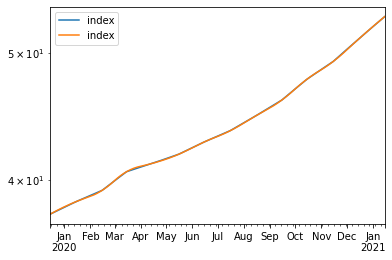

In [9]:
pd.options.display.max_rows = 99
## Interpolado a frecuencia diaria (util para llevar al "dia de hoy")

fig, ax = plt.subplots()
(cpi/cpi.loc['2003-01-15']).reindex(pd.date_range(
    start = '2019-12-15', end = '2021-01-15', freq = 'd')).interpolate(method = 'time').plot(ax = ax)
(cpi/cpi.loc['2003-01-15']).reindex(pd.date_range(
    start = '2019-12-15', end = '2021-01-15', freq = 'd')).interpolate(method = 'quadratic').plot(ax = ax)
ax.set_yscale('log')

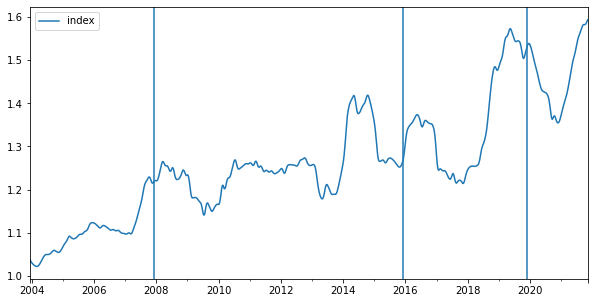

In [10]:
cpi_d = cpi.reindex(pd.date_range(
    start = '2002-12-15', end = '2021-12-15', freq = 'd')).interpolate(method = 'quadratic')
fig, ax = plt.subplots(1, figsize = (10, 5))
(cpi_d/cpi_d.shift(365)).dropna().plot(ax = ax)
ax.axvline('2007-12')
ax.axvline('2015-12')
ax.axvline('2019-12')

In [11]:
# index_d = (cpi_d/cpi_d.loc['2016-01-01']).dropna()
index_d = cpi_d.dropna()
index_d.to_csv('./../data/info/indice_precios_d.csv')

In [12]:
# display(index_d.loc[index_d['index'] >= .1].iloc[[0]])
# display(index_d.loc[index_d['index'] >= .2].iloc[[0]])
# display(index_d.loc[index_d['index'] >= .5].iloc[[0]])
# display(index_d.loc[index_d['index'] >= 1].iloc[[0]])
# display(index_d.loc[index_d['index'] >= 2].iloc[[0]])
# display(index_d.loc[index_d['index'] >= 5].iloc[[0]])

In [13]:
(index_d/index_d.shift(365)).iloc[-365*5:].mean()

index    1.402422
dtype: float64

In [14]:
100*cpi.tail(12).pct_change().round(4)

,index
2020-12-15,NaN
2021-01-15,4.05
2021-02-15,3.57
2021-03-15,4.81
2021-04-15,3.89
2021-05-15,3.89
2021-06-15,3.89
2021-07-15,3.89
2021-08-15,3.89
2021-09-15,3.89


In [15]:
cpi_ = cpi.groupby(pd.Grouper(freq='Q')).mean().loc['2003':][['index']]#.to_csv(...)

### Convenciones para fijar fecha de cuatrimestre.
cpi_.index = cpi_.index - pd.to_timedelta(cpi_.index.day - 15, unit='d') - pd.DateOffset(months=1)
cpi_.index.name = 'Q'

cpi_.tail()

,index
Q,
2020-11-15,3117.767507
2021-02-15,3499.395012
2021-05-15,3942.964456
2021-08-15,4421.680813
2021-11-15,4863.241648


In [16]:
from datetime import datetime

In [17]:
cpi_.to_csv('./../data/info/indice_precios_Q.csv')

In [18]:
# cpi = cpi.groupby(pd.Grouper(freq='Q')).mean().loc[str(startyr):str(endyr)][['index']]#.to_csv(...)
# cpi.set_index('index')
# cpi.index.name = 'Q'
# #
# indice_precios = cpi